In [115]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input, merge
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.models import Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-images")

HOLIDAY_FILE_IDS = os.path.join(DATA_DIR, "holiday-ids.txt")
HOLIDAY_VECS_FILE = os.path.join(DATA_DIR, "holiday-vecs.npy")

File naming conventions are as follows:

* first 4 numbers of filename prefix refer to the group
* next 2 numbers refer to the image in the group.

For example: 100000.jpg and 100002.jpg are "similar", but 123700.jpg is "different".

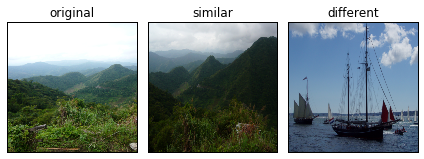

In [3]:
def show_img(sid, img_file, img_title):
    plt.subplot(sid)
    plt.title(img_title)
    plt.xticks([])
    plt.yticks([])
    img = imresize(plt.imread(img_file), (512, 512))
    plt.imshow(img)
    
show_img(131, os.path.join(IMAGE_DIR, "100000.jpg"), "original")
show_img(132, os.path.join(IMAGE_DIR, "100002.jpg"), "similar")
show_img(133, os.path.join(IMAGE_DIR, "123700.jpg"), "different")
plt.tight_layout()
plt.show()

## Vectorize Images with VGG-16

In [4]:
vgg16_model = vgg16.VGG16(weights="imagenet", include_top=True)
for layer in vgg16_model.layers:
    print(layer.name, layer.input_shape, layer.output_shape)

input_1 (None, 224, 224, 3) (None, 224, 224, 3)
block1_conv1 (None, 224, 224, 3) (None, 224, 224, 64)
block1_conv2 (None, 224, 224, 64) (None, 224, 224, 64)
block1_pool (None, 224, 224, 64) (None, 112, 112, 64)
block2_conv1 (None, 112, 112, 64) (None, 112, 112, 128)
block2_conv2 (None, 112, 112, 128) (None, 112, 112, 128)
block2_pool (None, 112, 112, 128) (None, 56, 56, 128)
block3_conv1 (None, 56, 56, 128) (None, 56, 56, 256)
block3_conv2 (None, 56, 56, 256) (None, 56, 56, 256)
block3_conv3 (None, 56, 56, 256) (None, 56, 56, 256)
block3_pool (None, 56, 56, 256) (None, 28, 28, 256)
block4_conv1 (None, 28, 28, 256) (None, 28, 28, 512)
block4_conv2 (None, 28, 28, 512) (None, 28, 28, 512)
block4_conv3 (None, 28, 28, 512) (None, 28, 28, 512)
block4_pool (None, 28, 28, 512) (None, 14, 14, 512)
block5_conv1 (None, 14, 14, 512) (None, 14, 14, 512)
block5_conv2 (None, 14, 14, 512) (None, 14, 14, 512)
block5_conv3 (None, 14, 14, 512) (None, 14, 14, 512)
block5_pool (None, 14, 14, 512) (None, 7,

In [5]:
vgg16_vec = Model(input=vgg16_model.input, 
                 output=vgg16_model.get_layer("fc2").output)
vgg16_vec.compile(optimizer="adam", loss="categorical_crossentropy")

In [10]:
BATCH_SIZE = 64
RESIZED_WH = 224
VECTOR_SIZE = 4096

def batch_vectorize(model, image_dir, target_wh, image_filenames_batch):
    batch_size = len(image_filenames_batch)
    X = np.zeros((batch_size, target_wh, target_wh, 3))
    bid = 0
    for image_filename in image_filenames_batch:
        img = plt.imread(os.path.join(image_dir, image_filename))
        img = imresize(img, (target_wh, target_wh))
        X[bid] = img
        bid += 1
    Y = model.predict(X)
    return Y

def generate_image_batch(image_filenames, batch_size):
    num_batches = (len(image_filenames) // batch_size)
    for i in range(num_batches):
        batch = image_filenames[i * batch_size : (i + 1) * batch_size]
        yield batch
    batch = image_filenames[(i+1) * batch_size:]
    yield batch    

def load_holiday_vectors(holiday_vecs_file):
    return np.load(holiday_vecs_file)

def maybe_load_holiday_vectors(image_dir, holiday_vecs_file, model,
                              batch_size, vector_size, target_wh):
    if os.path.exists(holiday_vecs_file):
        print("loading precomputed vectors...")
        V = load_holiday_vectors(holiday_vecs_file)
        return V
    else:
        print("computing vectors...")
        image_filenames = []
        for image_filename in os.listdir(image_dir):
            image_filenames.append(image_filename)
        num_batches = (len(image_filenames) // batch_size) + 1
        curr_batch = 0
        V = np.zeros((len(image_filenames), vector_size))
        fhfi = open(HOLIDAY_FILE_IDS, "wb")
        for image_batch in generate_image_batch(image_filenames, batch_size):
            print("Batch {:d}/{:d}: {:s} - {:s} ({:d} - {:d}/{:d})".format(
                    curr_batch + 1, num_batches, 
                    image_batch[0], image_batch[-1],
                    curr_batch * batch_size, 
                    (curr_batch * batch_size) + len(image_batch),
                    len(image_filenames)))
            Y = batch_vectorize(model, image_dir, target_wh, image_batch)
            for i in range(Y.shape[0]):
                img_id = batch_size * curr_batch + i
                V[img_id] = Y[i]
                fhfi.write("{:s}\t{:d}\n".format(image_batch[i], img_id))
            curr_batch += 1
        fhfi.close()
        np.save(holiday_vecs_file, V)
        return V

V = maybe_load_holiday_vectors(IMAGE_DIR, HOLIDAY_VECS_FILE, vgg16_vec,
                               BATCH_SIZE, VECTOR_SIZE, RESIZED_WH)
V.shape

loading precomputed vectors...


(1491, 4096)

## Create Image Triples (positive and negative)

In [12]:
def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"
    
def create_triples(image_dir):
    img_groups = {}
    for img_file in os.listdir(image_dir):
        prefix, suffix = img_file.split(".")
        gid, pid = prefix[0:4], prefix[4:]
        if img_groups.has_key(gid):
            img_groups[gid].append(pid)
        else:
            img_groups[gid] = [pid]
    pos_triples, neg_triples = [], []
    # positive pairs are any combination of images in same group
    for key in img_groups.keys():
        triples = [(key + x[0] + ".jpg", key + x[1] + ".jpg", 1) 
                 for x in itertools.combinations(img_groups[key], 2)]
        pos_triples.extend(triples)
    # need equal number of negative examples
    group_names = list(img_groups.keys())
    for i in range(len(pos_triples)):
        g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
        left = get_random_image(img_groups, group_names, g1)
        right = get_random_image(img_groups, group_names, g2)
        neg_triples.append((left, right, 0))
    pos_triples.extend(neg_triples)
    shuffle(pos_triples)
    return pos_triples

triples_data = create_triples(IMAGE_DIR)

print(len(triples_data))
print(triples_data[0:5])

4144
[('101404.jpg', '141704.jpg', 0), ('138005.jpg', '138008.jpg', 1), ('129700.jpg', '107101.jpg', 0), ('103300.jpg', '103301.jpg', 1), ('113000.jpg', '110501.jpg', 0)]


## Split into training and test

In [15]:
triples_train, triples_test = train_test_split(triples_data, train_size=0.7)
print(len(triples_train), len(triples_test))

2900 1244


## Build data generator

We want to build a generator that will use the pairs_data to generate pairs of input vectors using the matrix that we precomputed earlier.

In [62]:
def load_image2id(holiday_file_ids):
    image2id = {}
    fin = open(holiday_file_ids, "rb")
    for line in fin:
        image_name, image_id = line.strip().split("\t")
        image2id[image_name] = int(image_id)
    fin.close()
    return image2id

def generate_image_triples_batch(triples, image2id, holiday_vectors, batch_size):
    while True:
        # loop once per epoch
        indices = np.random.permutation(np.arange(len(triples)))
        shuffled_pairs = [triples[ix] for ix in indices]
        num_batches = len(shuffled_pairs) // batch_size
        for bid in range(num_batches):
            # loop once per batch
            Xlhs = np.zeros((batch_size, VECTOR_SIZE))
            Xrhs = np.zeros((batch_size, VECTOR_SIZE))
            Y = np.zeros((batch_size,), dtype="int")
            batch = shuffled_pairs[bid * batch_size : (bid + 1) * batch_size]
            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                Xlhs[i] = holiday_vectors[image2id[lhs]]
                Xrhs[i] = holiday_vectors[image2id[rhs]]
                Y[i] = label
            Y = np_utils.to_categorical(Y, nb_classes=2)
            yield ([Xlhs, Xrhs], Y)

image2id = load_image2id(HOLIDAY_FILE_IDS)
train_gen = generate_image_triples_batch(triples_train, image2id, V, BATCH_SIZE)
test_gen = generate_image_triples_batch(triples_test, image2id, V, BATCH_SIZE)

## Define model

Custom function for Lambda layer.

In [93]:
def euclidean_distance(vecs):
    x, y = vecs
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def euclidean_distance_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [117]:
lhs_input = Input(shape=(VECTOR_SIZE,))
rhs_input = Input(shape=(VECTOR_SIZE,))

lhs = Dense(1024, init="glorot_uniform", activation="relu")(lhs_input)
lhs = Dropout(0.2)(lhs)

rhs = Dense(1024, init="glorot_uniform", activation="relu")(rhs_input)
rhs = Dropout(0.2)(rhs)

sim = Lambda(euclidean_distance, output_shape=euclidean_distance_output_shape)([lhs, rhs])
sim = Dropout(0.1)(sim)
sim = Activation("relu")(sim)

sim = Dense(128)(sim)
sim = Dropout(0.1)(sim)

prediction = Dense(2, activation="softmax")(sim)

sim_model = Model(input=[lhs_input, rhs_input], output=[prediction])
sim_model.compile(optimizer="adam", loss=contrastive_loss)

## Train Model

Custom Loss function from [Contrastive loss from Hadsell-et-al.'06](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf).

In [118]:
def contrastive_loss(y, y_):
    margin = 1
    return K.mean(y * K.square(y_) + (1 - y) * K.square(K.maximum(margin - y_, 0)))

In [119]:
NUM_EPOCHS = 10

num_train_samples = (len(triples_train) // BATCH_SIZE) * BATCH_SIZE
num_test_samples = (len(triples_test) // BATCH_SIZE) * BATCH_SIZE
history = sim_model.fit_generator(train_gen,
                                 samples_per_epoch=num_train_samples,
                                 nb_epoch=NUM_EPOCHS,
                                 validation_data=test_gen,
                                 nb_val_samples=num_test_samples)

Epoch 1/10
2880/2880 [==============================] - 5s - loss: 0.2645 - val_loss: 0.2505
Epoch 2/10
2880/2880 [==============================] - 5s - loss: 0.2499 - val_loss: 0.2508
Epoch 3/10
2880/2880 [==============================] - 5s - loss: 0.2502 - val_loss: 0.2505
Epoch 4/10
2880/2880 [==============================] - 5s - loss: 0.2503 - val_loss: 0.2498
Epoch 5/10
2880/2880 [==============================] - 5s - loss: 0.2501 - val_loss: 0.2504
Epoch 6/10
2880/2880 [==============================] - 6s - loss: 0.2501 - val_loss: 0.2502
Epoch 7/10
2880/2880 [==============================] - 5s - loss: 0.2504 - val_loss: 0.2498
Epoch 8/10
2880/2880 [==============================] - 5s - loss: 0.2502 - val_loss: 0.2504
Epoch 9/10
2880/2880 [==============================] - 5s - loss: 0.2500 - val_loss: 0.2504
Epoch 10/10
2880/2880 [==============================] - 5s - loss: 0.2501 - val_loss: 0.2498


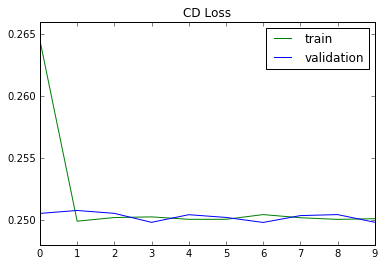

In [120]:
plt.title("CD Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")
plt.show()

## Predictions

In [121]:
[Xtest_lhs, Xtest_rhs], Ytest = test_gen.next()
Ytest_ = sim_model.predict([Xtest_lhs, Xtest_rhs])
print(np_utils.categorical_probas_to_classes(Ytest_))
print(np_utils.categorical_probas_to_classes(Ytest))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0
 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0]
